# Import

In [1]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from causalml.inference.meta import (
    BaseDRLearner,
    BaseRLearner,
    BaseXLearner,
    BaseSLearner,
    BaseTLearner,
    BaseRClassifier,
    BaseXClassifier,
    BaseTClassifier,
    BaseSClassifier,
)
from causalml.inference.torch import CEVAE

from cate.dataset import Dataset

/workspace/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
def to_rank(
    primary_key: pd.Series, score: pd.Series, ascending: bool = True
) -> pd.Series:
    df = pd.DataFrame({primary_key.name: primary_key, score.name: score}).set_index(
        primary_key.name, drop=True
    )
    df = df.sort_values(by=score.name, ascending=ascending)  # type: ignore
    df["rank"] = np.ceil(np.arange(len(df)) / len(df) * 100).astype(int)
    return df["rank"]

# Read Data

In [3]:
original_df = pd.read_csv(
    "/workspace/data/uplift-modeling/criteo-uplift-v2.1.csv"
)
base_df = original_df.sample(frac=0.05, random_state=0)

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/data/uplift-modeling/criteo-uplift-v2.1.csv'

In [5]:
ds = Dataset(
    base_df,
    ["f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11"],
    ["conversion"],
    ["treatment"],
)

# Model

In [6]:
# base_model = lgb.LGBMClassifier(importance_type="gain")
# names = [
#     "slearner",
#     "tlearner",
#     "xlearner",
#     "drlearner",
#     "rlearner",
#     "cevae",
# ]
# models = [
#     BaseSLearner(base_model),
#     BaseTLearner(base_model, base_model, base_model),
#     BaseXLearner(base_model, base_model, base_model),
#     BaseDRLearner(base_model, base_model, base_model, base_model),
#     BaseRLearner(base_model, base_model, base_model),
#     CEVAE(),
# ]

In [9]:
base_classifier = lgb.LGBMClassifier(importance_type="gain")
base_regressor = lgb.LGBMRegressor(importance_type="gain")
names = [
    "slearner",
    "tlearner",
    # "xlearner",
    # "rlearner",
    # "cevae",
]

models = [
    BaseSClassifier(base_classifier),
    BaseTClassifier(base_classifier, base_classifier, base_regressor),
    # BaseXClassifier(base_classifier, base_regressor),
    # BaseRClassifier(base_classifier, base_regressor),
    # CEVAE(),
]

In [10]:
np.int = int

In [11]:
pred_dfs = {}
skf = StratifiedKFold(5, shuffle=True, random_state=42)
for name, model in zip(names, models):
    _pred_dfs = []
    for train_idx, valid_idx in tqdm(skf.split(np.zeros(len(ds)), ds.y)):
        train_X = ds.X.iloc[train_idx]
        train_y = ds.y.iloc[train_idx].to_numpy().reshape(-1)
        train_w = ds.w.iloc[train_idx].to_numpy().reshape(-1)
        valid_X = ds.X.iloc[valid_idx]
        valid_y = ds.y.iloc[valid_idx].to_numpy().reshape(-1)
        valid_w = ds.w.iloc[valid_idx].to_numpy().reshape(-1)
        model.fit(train_X, train_w, train_y)
        pred = model.predict(valid_X)
        _pred_dfs.append(
            pd.DataFrame({"index": ds.y.index[valid_idx], "pred": pred.reshape(-1)})
        )  # type: ignore
    pred_dfs[name] = _pred_dfs

0it [00:00, ?it/s]

/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarn

[LightGBM] [Info] Number of positive: 42, number of negative: 16730
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1611
[LightGBM] [Info] Number of data points in the train set: 16772, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002504 -> initscore=-5.987289
[LightGBM] [Info] Start training from score -5.987289
[LightGBM] [Info] Number of positive: 299, number of negative: 94765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1673
[LightGBM] [Info] Number of data points in the train set: 95064, number of used features: 12
[LightGBM] [Info] [bina

1it [02:36, 156.74s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 40, number of negative: 16731
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1615
[LightGBM] [Info] Number of data points in the train set: 16771, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002385 -> initscore=-6.036139
[LightGBM] [Info] Start training from score -6.036139
[LightGBM] [Info] Number of positive: 302, number of negative: 94764
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 95066, number of used features: 12
[LightGBM] [Info] [bina

2it [05:10, 155.19s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 36, number of negative: 16642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1610
[LightGBM] [Info] Number of data points in the train set: 16678, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002159 -> initscore=-6.136166
[LightGBM] [Info] Start training from score -6.136166
[LightGBM] [Info] Number of positive: 306, number of negative: 94853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 95159, number of used features: 12
[LightGBM] [Info] [bina

3it [07:44, 154.37s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 38, number of negative: 16713
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1618
[LightGBM] [Info] Number of data points in the train set: 16751, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002269 -> initscore=-6.086356
[LightGBM] [Info] Start training from score -6.086356
[LightGBM] [Info] Number of positive: 304, number of negative: 94782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1675
[LightGBM] [Info] Number of data points in the train set: 95086, number of used features: 12
[LightGBM] [Info] [bina

4it [10:18, 154.50s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 40, number of negative: 16668
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] Number of data points in the train set: 16708, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002394 -> initscore=-6.032367
[LightGBM] [Info] Start training from score -6.032367
[LightGBM] [Info] Number of positive: 301, number of negative: 94828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1671
[LightGBM] [Info] Number of data points in the train set: 95129, number of used features: 12
[LightGBM] [Info] [bina

5it [12:50, 154.05s/it]
0it [00:00, ?it/s]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn

[LightGBM] [Info] Number of positive: 269, number of negative: 89200
[LightGBM] [Info] Number of positive: 292, number of negative: 89177
[LightGBM] [Info] Number of positive: 266, number of negative: 89203
[LightGBM] [Info] Number of positive: 285, number of negative: 89183
[LightGBM] [Info] Number of positive: 252, number of negative: 89217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set 

1it [02:50, 170.28s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 275, number of negative: 89195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1669
[LightGBM] [Info] Number of data points in the train set: 89470, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003074 -> initscore=-5.781809
[LightGBM] [Info] Start training from score -5.781809
[LightGBM] [Info] Number of positive: 281, number of negative: 89189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1673
[LightGBM] [Info] Number of data points in the train set: 89470, number of used features: 12
[LightGBM] [Info] [bin

2it [05:30, 164.61s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 280, number of negative: 89189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1666
[LightGBM] [Info] Number of data points in the train set: 89469, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003130 -> initscore=-5.763723
[LightGBM] [Info] Start training from score -5.763723
[LightGBM] [Info] Number of positive: 264, number of negative: 89205
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 89469, number of used features: 12
[LightGBM] [Info] [bin

3it [08:07, 160.82s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 275, number of negative: 89194
[LightGBM] [Info] Number of positive: 290, number of negative: 89180
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 89469, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003074 -> initscore=-5.781798
[LightGBM] [Info] Start training from score -5.781798
[LightGBM] [Info] Number of positive: 278, number of negative: 89191
[LightGBM] [Info] Number of positive: 259, number of negative: 89211
[LightGBM] [Info] Number of positive: 266, number of negative: 89204
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if

4it [10:43, 159.10s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1677
[LightGBM] [Info] Number of data points in the train set: 111837, number of used features: 12
[LightGBM] [Info] Start training from score 0.001159


/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarn

[LightGBM] [Info] Number of positive: 271, number of negative: 89198
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1673
[LightGBM] [Info] Number of data points in the train set: 89469, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003029 -> initscore=-5.796495
[LightGBM] [Info] Start training from score -5.796495
[LightGBM] [Info] Number of positive: 273, number of negative: 89196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 89469, number of used features: 12
[LightGBM] [Info] [bin

5it [13:20, 160.10s/it]


In [15]:
output_df = base_df.copy()
for name, pred_df_list in pred_dfs.items():
    pred_df = pd.concat(pred_df_list, axis=0)
    rank = to_rank(pred_df["index"], pred_df["pred"], ascending=False)
    pred_df = pd.merge(pred_df, rank, left_on="index", right_index=True).set_index(
        "index", drop=True
    )
    pred_df = pred_df.rename(columns={"pred": f"{name}_pred", "rank": f"{name}_rank"})
    output_df = pd.merge(output_df, pred_df, left_index=True, right_index=True)

In [16]:
cvs = {}
for name in names:
    cv_list = []
    for rank in range(100):
        rank_flg = output_df[f"{name}_rank"] <= rank
        tg_flg = output_df["treatment"] == 1
        cv = (
            output_df.loc[rank_flg & tg_flg, "conversion"].mean()
            - output_df.loc[rank_flg & ~tg_flg, "conversion"].mean()
        )
        cv_list.append(cv)
    cvs[name] = cv_list

In [17]:
output_df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,xlearner_pred,xlearner_rank,rlearner_pred,rlearner_rank
1970622,21.968147,10.059654,8.297974,4.679882,10.280525,4.115453,-4.595460,4.833815,3.874503,18.380112,5.300375,-0.168679,1,0,1,0,-0.000135,87,0.000485,23
3715222,22.331824,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,-0.000044,78,0.000050,45
10995663,24.717702,10.059654,8.801247,4.679882,10.280525,4.115453,-4.595460,4.833815,3.934656,13.190056,5.300375,-0.168679,1,0,0,0,0.000006,65,-0.000321,81
7211757,12.616365,10.059654,8.911909,4.679882,10.280525,4.115453,0.294443,4.833815,3.845448,13.190056,5.300375,-0.168679,1,0,0,0,0.000255,35,0.000753,15
3427333,21.245639,10.059654,8.949112,4.679882,10.280525,4.115453,-12.570178,4.833815,3.943716,13.190056,5.300375,-0.168679,1,0,0,1,0.001828,12,-0.000718,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9018893,20.785032,10.059654,8.625421,4.679882,10.280525,4.115453,-1.288207,4.833815,3.899112,25.954644,5.300375,-0.168679,1,0,1,0,0.002422,11,0.000862,14
7745965,23.419176,10.059654,8.214383,4.679882,10.280525,4.115453,-3.993764,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,1,0.000389,28,-0.000493,91
3013167,22.339318,10.059654,8.214383,4.679882,10.280525,4.115453,-5.116672,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,-0.000044,79,0.000050,45
6126603,26.335296,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0,0.191749,1,-0.000570,95


In [18]:
cv_df = pd.DataFrame(cvs)

In [1]:
cv_df.to_csv("/workspace/outputs/_meta_learner.csv", index=False)

NameError: name 'cv_df' is not defined

<Axes: >

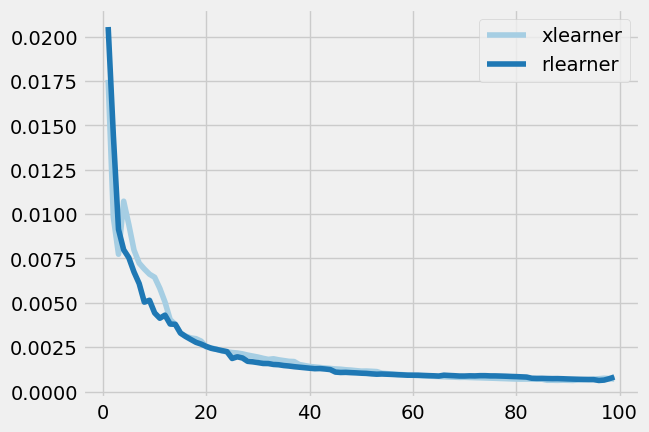

In [20]:
cv_df.plot()